# Kaggle - New York City Taxi Trip Duration
## EDA and Preprocessing
### Data
[Kaggle - New York City Taxi Trip Duration](https://www.kaggle.com/competitions/nyc-taxi-trip-duration/data)
### 사용 라이브러리

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
from xgboost import XGBRegressor
import lightgbm as lgbm
from lightgbm import LGBMRegressor

### Data Load

In [2]:
path = glob.glob("data/*")
path

['data\\pre_test.csv',
 'data\\pre_train.csv',
 'data\\sample_submission.zip',
 'data\\test.zip',
 'data\\train.zip']

In [3]:
train, test = pd.read_csv(path[-1]), pd.read_csv(path[-2])

train.shape, test.shape

((1458644, 11), (625134, 9))

In [5]:
display(train.head())
display(test.head())

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


- `vendor_id`: 제공회사
- `store_and_fwd_flag`: 회사로 데이터를 전송하는지

### EDA and Preprocessing
#### 기본정보

In [7]:
display(train.dtypes)
display(test.dtypes)

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

id                     object
vendor_id               int64
pickup_datetime        object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
dtype: object

#### 결측치

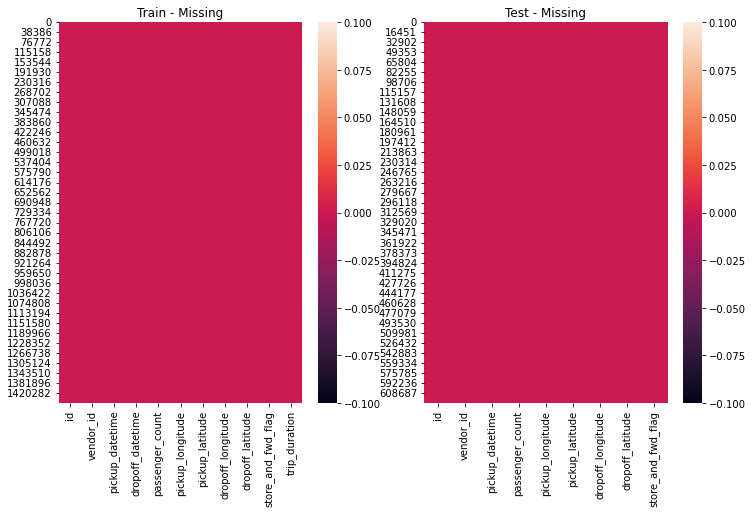

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))
sns.heatmap(train.isnull(), ax=ax[0]).set_title("Train - Missing")
sns.heatmap(test.isnull(), ax=ax[1]).set_title("Test - Missing")
plt.show()

결측치가 없는 데이터임

#### 중복값

In [13]:
train[train.duplicated()]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration


In [14]:
test[test.duplicated()]

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag


중복값도 없음

#### vendor_id

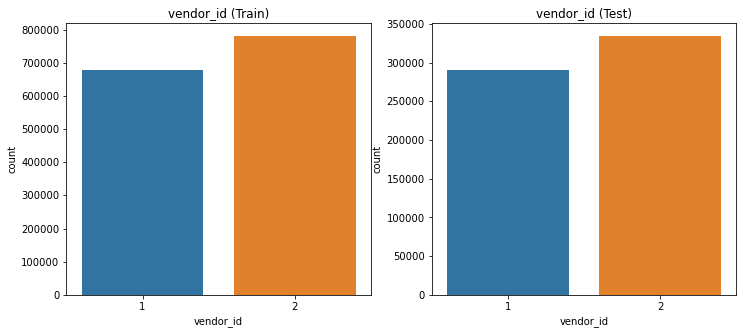

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(x=train["vendor_id"], ax=ax[0]).set_title("vendor_id (Train)")
sns.countplot(x=test["vendor_id"], ax=ax[1]).set_title("vendor_id (Test)")
plt.show()

#### pickup_datetime / dropoff_datetime

In [4]:
train["pickup_datetime"] = pd.to_datetime(train["pickup_datetime"])
train["dropoff_datetime"] = pd.to_datetime(train["dropoff_datetime"])

test["pickup_datetime"] = pd.to_datetime(test["pickup_datetime"])

In [5]:
# train - pickup
train["p_year"] = train["pickup_datetime"].dt.year
train["p_month"] = train["pickup_datetime"].dt.month
train["p_day"] = train["pickup_datetime"].dt.day
train["p_dow"] = train["pickup_datetime"].dt.dayofweek
train["p_hour"] = train["pickup_datetime"].dt.hour
train["p_min"] = train["pickup_datetime"].dt.minute

In [41]:
# # train - dropoff
# train["d_year"] = train["dropoff_datetime"].dt.year
# train["d_month"] = train["dropoff_datetime"].dt.month
# train["d_day"] = train["dropoff_datetime"].dt.day
# train["d_dow"] = train["dropoff_datetime"].dt.dayofweek
# train["d_hour"] = train["dropoff_datetime"].dt.hour
# train["d_min"] = train["dropoff_datetime"].dt.minute

`dropoff_datetime`은 `test`에 없으므로 사용 안함

In [6]:
# test - pickup
test["p_year"] = test["pickup_datetime"].dt.year
test["p_month"] = test["pickup_datetime"].dt.month
test["p_day"] = test["pickup_datetime"].dt.day
test["p_dow"] = test["pickup_datetime"].dt.dayofweek
test["p_hour"] = test["pickup_datetime"].dt.hour
test["p_min"] = test["pickup_datetime"].dt.minute

In [7]:
date = ["p_year", "p_month", "p_day", "p_dow", "p_hour", "p_min"]

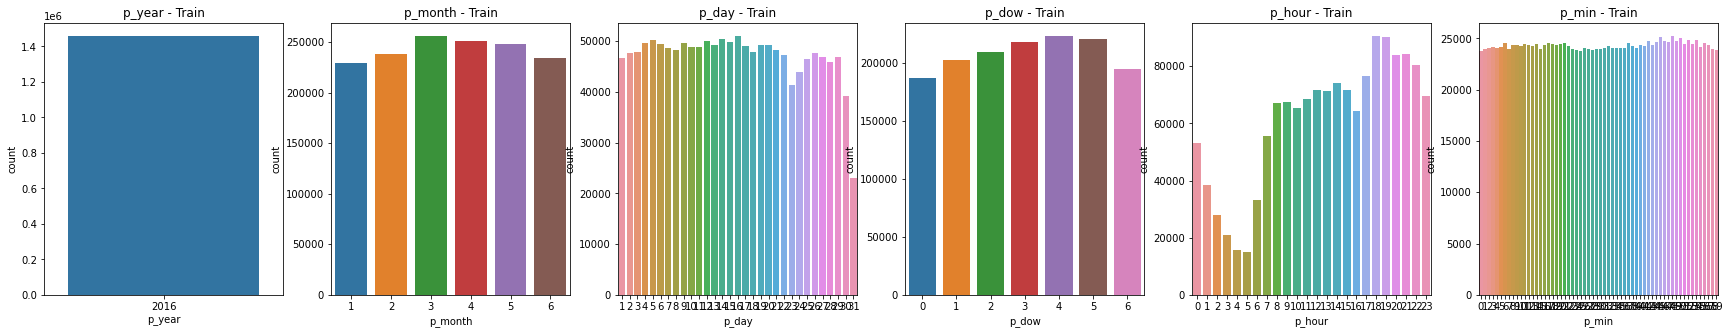

In [10]:
fig, ax = plt.subplots(1, len(date), figsize=(30, 5))
for col, ax in zip(date, ax):
    sns.countplot(x=train[col], ax=ax).set_title(f"{col} - Train")
plt.show()

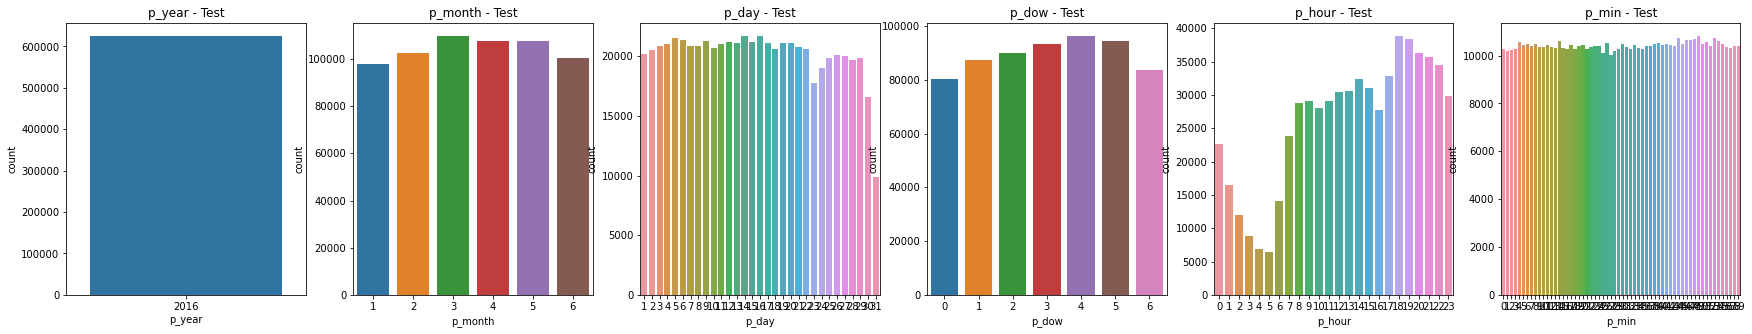

In [11]:
fig, ax = plt.subplots(1, len(date), figsize=(30, 5))
for col, ax in zip(date, ax):
    sns.countplot(x=test[col], ax=ax).set_title(f"{col} - Test")
plt.show()

2016년 상반기(1~6) 데이터임  
이동 거리를 예측해야하는 문제라 `test`에는 `dropoff_datetime`이 없는 듯

#### longitude / latitude

In [8]:
cor = ["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]

#### Haversine formula
$ haversine(θ) = sin²{θ \over 2} $  

a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)  
c = 2 * atan2( √a, √(1−a) )  
d = R ⋅ c  
d = Haversine distance

In [9]:
def haversine_distance(lat1, long1, lat2, long2):
    data = [train, test]
    for _ in data:
        R = 6371 # km, 지구의 반지름
        phi1 = np.radians(_[lat1])
        phi2 = np.radians(_[lat2])
        
        delta_phi = np.radians(_[lat2]-_[lat1])
        delta_lambda = np.radians(_[long2]-_[long2])
        
        a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
        d = (R * c)
        _["H_Distance"] = d
    return d

In [10]:
haversine_distance('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

0          2.741019
1          2.734232
2          0.896282
3          4.606964
4          0.620992
            ...    
625129     0.949304
625130     4.301558
625131     1.245378
625132    17.593930
625133     5.837496
Length: 625134, dtype: float64

#### passenger_count

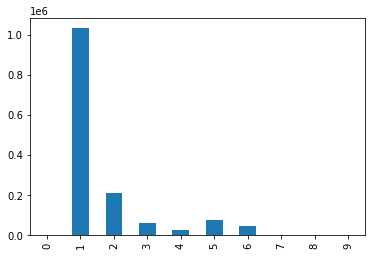

In [102]:
_ = (train["passenger_count"].value_counts().sort_index()).plot.bar()

In [103]:
train["passenger_count"].value_counts().sort_index()

0         60
1    1033540
2     210318
3      59896
4      28404
5      78088
6      48333
7          3
8          1
9          1
Name: passenger_count, dtype: int64

0, 7, 8, 9명이 탄것은 이상치  
5명 이상도 조금 이상한거 같지만, 대형 택시라고 생각함

In [11]:
cond1 = train["passenger_count"]==0
cond2 = train["passenger_count"]==7
cond3 = train["passenger_count"]==8
cond4 = train["passenger_count"]==9

cond = cond1 | cond2 | cond3 | cond4

In [12]:
train = train[~cond]

#### store_and_fwd_flag

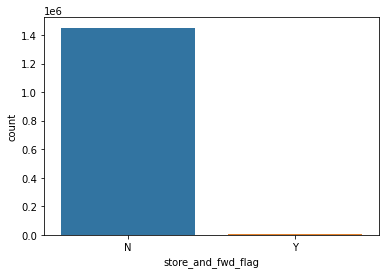

In [114]:
_ = sns.countplot(x=train["store_and_fwd_flag"])

## Model - Regressor
### Train Data Split

In [13]:
label = "trip_duration"
features = train.columns.tolist()
features.remove(label)
features.remove("id")
features.remove("pickup_datetime")
features.remove("dropoff_datetime")
features

['vendor_id',
 'passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'store_and_fwd_flag',
 'p_year',
 'p_month',
 'p_day',
 'p_dow',
 'p_hour',
 'p_min',
 'H_Distance']

In [14]:
train["store_and_fwd_flag"] = pd.get_dummies(train["store_and_fwd_flag"], drop_first=True)
test["store_and_fwd_flag"] = pd.get_dummies(test["store_and_fwd_flag"], drop_first=True)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(train[features], train[label], test_size=0.3)

print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_test: {X_test.shape}\ny_test: {y_test.shape}")

X_train: (1021005, 14)
y_train: (1021005,)
X_test: (437574, 14)
y_test: (437574,)


#### Random Forest

In [16]:
reg_rf = RandomForestRegressor()

pred_rf = reg_rf.fit(X_train, y_train).predict(X_test)

mean_squared_log_error(y_test, pred_rf)

0.3483171563954924

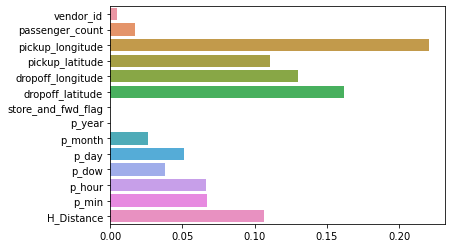

In [17]:
_ = sns.barplot(x=reg_rf.feature_importances_, y=reg_rf.feature_names_in_)

#### XGBoost

In [18]:
reg_xgb = XGBRegressor()

pred_xgb = reg_xgb.fit(X_train, y_train).predict(X_test)

mean_squared_log_error(y_test, abs(pred_xgb))

0.3297185297357314

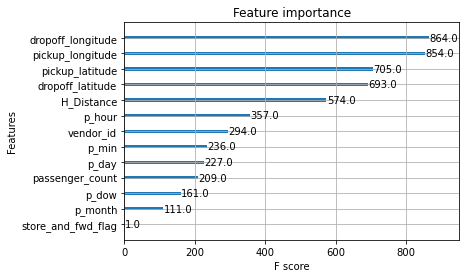

In [19]:
_ = xgb.plot_importance(reg_xgb)

#### LGBM

In [20]:
reg_lgbm = LGBMRegressor()

pred_lgbm = reg_lgbm.fit(X_train, y_train).predict(X_test)

mean_squared_log_error(y_test, abs(pred_lgbm))

0.3620231060763725

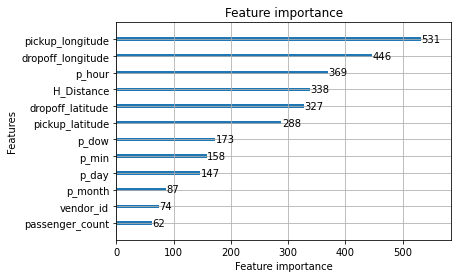

In [21]:
_ = lgbm.plot_importance(reg_lgbm)